---

In [3]:
import pybullet as p
import numpy as np

from pybullet_robot import PyBulletRobot, W, H

import sys, glob
import pandas as pd 

import matplotlib.pyplot as plt

In [16]:
from IPython.display import clear_output
from matplotlib import pyplot as plt
import collections
%matplotlib inline

def live_plot(data_dict, figsize=(7,5), title=''):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    for label,data in data_dict.items():
        plt.plot(data, label=label)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.legend(loc='center left') # the plot evolves to the right
    plt.show();

In [4]:
gui = True
r = PyBulletRobot(4, 1, render=gui)

*** Initializing PyBulletRobot(ns=4, render=True) ...
*** Initializing PyBulletRobot() done


In [ ]:
# load csv
fnames = "goodphis-*.csv"
phiss = None
for fname in glob.glob(fnames):
    df = pd.read_csv(fname)
    if phiss is None:
        phiss = df
    else:
        phiss = pd.concat([phiss, df])
phiss = phiss.values[1:,1:]
print(phiss.shape)

In [ ]:
for i in range(6):
    plt.hist(phiss[:,i])
    plt.show()

---

In [ ]:
X = np.zeros((phiss.shape[0], 9))
Y = np.zeros(phiss.shape)

for i in range(phiss.shape[0]):
    phis = phiss[i]
    r.step(phis.reshape(-1, 2))
    cam_p, cam_v, cam_u = r.getHeadcamPVU()
    Y[i] = phis
    X[i] = list(cam_p) + list(cam_v) + list(cam_u)
print(X.shape)
print(Y.shape)

In [11]:
import tensorflow as tf

def mk_model():
    inputs = tf.keras.Input(shape=(9,))
    
    layer = tf.keras.layers.Dense(64, activation='relu')(inputs)
    for _ in range(5):
        layer = tf.keras.layers.Dense(64, activation='relu')(layer)
    outputs = tf.keras.layers.Dense(8, activation='tanh')(layer)

    model = tf.keras.Model(inputs, outputs)
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

    return model

model = mk_model()

print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_12 (Dense)             (None, 64)                4160

In [13]:
def plot_fh(history):
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

In [8]:
import numpy as np

MAX_PHI = np.pi/4
M = 500000

X = np.zeros((M, 9))
Y = np.zeros((M, 8))

for i in range(M):
    phis = np.zeros((r.NS, 2))
    phis[0,:] = np.random.uniform(low=-MAX_PHI, high=0, size=(2))
    phis[1,:] = np.random.uniform(low=-MAX_PHI, high=MAX_PHI, size=(2))
    phis[2,:] = phis[3,:] = np.random.uniform(low=-MAX_PHI, high=MAX_PHI, size=(2))
    r.step(phis)
    cam_p, cam_v, cam_u = r.getHeadcamPVU()
    Y[i] = phis.reshape(-1)
    X[i] = list(cam_p) + list(cam_v) + list(cam_u)
print(X.shape)
print(Y.shape)

(500000, 9)
(500000, 8)


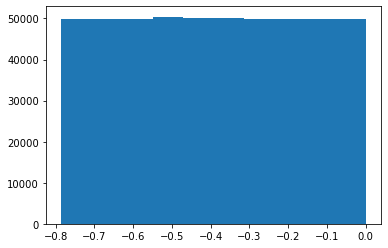

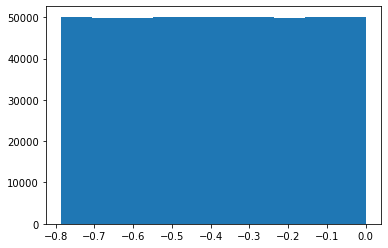

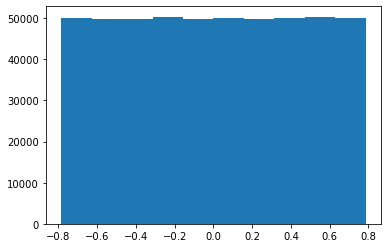

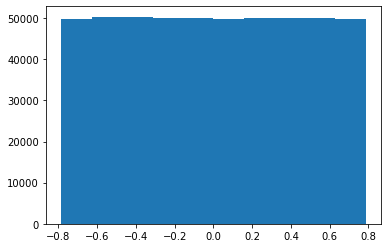

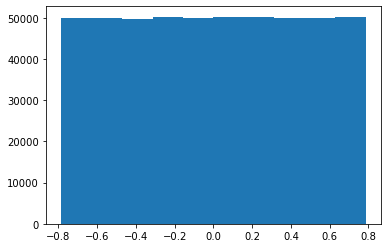

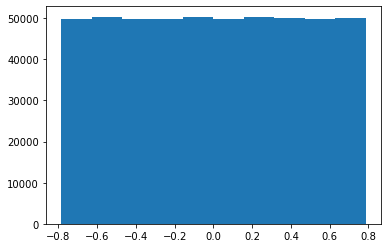

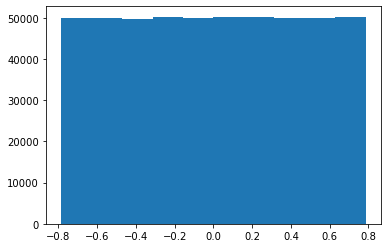

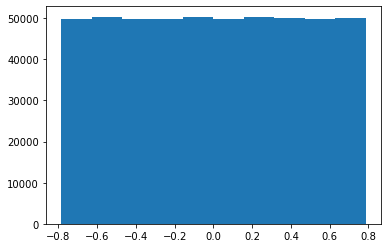

In [25]:
for i in range(8):
    plt.hist(Y[:,i])
    plt.show()

Train on 499000 samples, validate on 1000 samples
Epoch 1/50
499000/499000 [==============================] - 2s 4us/sample - loss: 0.0066 - mean_absolute_error: 0.0501 - val_loss: 0.0062 - val_mean_absolute_error: 0.0480
Epoch 2/50
499000/499000 [==============================] - 2s 4us/sample - loss: 0.0066 - mean_absolute_error: 0.0500 - val_loss: 0.0058 - val_mean_absolute_error: 0.0473
Epoch 3/50
499000/499000 [==============================] - 2s 4us/sample - loss: 0.0065 - mean_absolute_error: 0.0496 - val_loss: 0.0059 - val_mean_absolute_error: 0.0480
Epoch 4/50
499000/499000 [==============================] - 2s 4us/sample - loss: 0.0065 - mean_absolute_error: 0.0497 - val_loss: 0.0058 - val_mean_absolute_error: 0.0468
Epoch 5/50
499000/499000 [==============================] - 2s 4us/sample - loss: 0.0065 - mean_absolute_error: 0.0494 - val_loss: 0.0057 - val_mean_absolute_error: 0.0467
Epoch 6/50
499000/499000 [==============================] - 2s 4us/sample - loss: 0.0065 -

499000/499000 [==============================] - 2s 4us/sample - loss: 0.0060 - mean_absolute_error: 0.0469 - val_loss: 0.0055 - val_mean_absolute_error: 0.0449
Epoch 49/50
499000/499000 [==============================] - 2s 4us/sample - loss: 0.0060 - mean_absolute_error: 0.0465 - val_loss: 0.0056 - val_mean_absolute_error: 0.0467
Epoch 50/50
499000/499000 [==============================] - 2s 4us/sample - loss: 0.0060 - mean_absolute_error: 0.0467 - val_loss: 0.0051 - val_mean_absolute_error: 0.0435


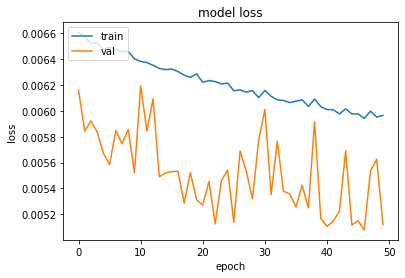

In [27]:
h = model.fit(X, Y, batch_size=1024, epochs=50, shuffle=True, validation_split=0.002)
plot_fh(h)

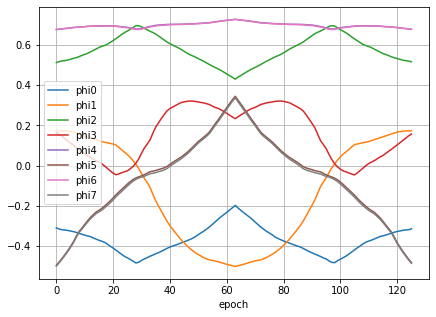

In [61]:
import time

def doit(alpha, beta):
    # inclination θ, azimuth φ
    theta = np.pi/2 - beta
    phi = alpha
    cam_vx = np.sin(theta) * np.cos(phi)
    cam_vy = np.sin(theta) * np.sin(phi)
    cam_vz = np.cos(theta)
       
    theta = -beta
    phi = alpha
    cam_ux = np.sin(theta) * np.cos(phi)
    cam_uy = np.sin(theta) * np.sin(phi)
    cam_uz = np.cos(theta)
    
    cam_v = [cam_vx, cam_vy, cam_vz]
    cam_u = [cam_ux, cam_uy, cam_uz]
    cam_p = [0.23, 0.0, 0.67]

    test_X = np.array([cam_p + cam_v + cam_u], dtype=np.float32)
    pred_phis = model.predict(test_X)
    r.step(pred_phis.reshape(-1,2))
    pvu = r.getHeadcamPVU()

    r.getCameraImage()
    return [cam_p, cam_v, cam_u], pvu, pred_phis.reshape(-1)

MAX_ALPHA = np.pi/4
D_ALPHA = 0.025

alpha = -MAX_ALPHA
dalpha = D_ALPHA

data = collections.defaultdict(list)

while True:
    pvu0, pvu1, phis = doit(alpha, 0)
    #time.sleep(0.01)
    
    if False:
        data['cam_vx0'].append(pvu0[1][0])
        data['cam_vx1'].append(pvu1[1][0])
        data['cam_vy0'].append(pvu0[1][1])
        data['cam_vy1'].append(pvu1[1][1])
        data['cam_vz0'].append(pvu0[1][2])
        data['cam_vz1'].append(pvu1[1][2])

    if False:
        data['cam_ux0'].append(pvu0[2][0])
        data['cam_ux1'].append(pvu1[2][0])
        data['cam_uy0'].append(pvu0[2][1])
        data['cam_uy1'].append(pvu1[2][1])
        data['cam_uz0'].append(pvu0[2][2])
        data['cam_uz1'].append(pvu1[2][2])

    if True:
        for i in range(phis.shape[0]):
            data['phi%d' % i].append(phis[i])
        
    live_plot(data)
          
    alpha += dalpha
    if dalpha > 0:
        if alpha > MAX_ALPHA:
            alpha = MAX_ALPHA
            dalpha = -D_ALPHA
    else:
        if alpha < -MAX_ALPHA:
            alpha = -MAX_ALPHA
            dalpha = D_ALPHA
            break
            

In [1]:
r.step(np.zeros((3,2)))
r.getHeadcamPVU()

NameError: name 'r' is not defined

In [60]:
MAX_PHI

0.7853981633974483